In [1]:
#TODO:
# solver class. for meta-heuristics, use wrapper that 
# - checks constraints feasibility and restarts if violated
# - gradually increases coeffs before constraints

In [2]:
import os, sys
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
# from collections import deque

import librosa
import scipy.signal

In [3]:
# project_root = "."

# sys.path.append(project_root)

In [4]:
from optim.utils import unpack_bounds

from dsp import load_fir
from dsp import resample
from dsp.filters.iir import load_sos, save_sos

In [5]:
from dsp.filters import parametric_eq, sos_general_parametric

In [6]:
from anc.problem import ProblemFeedback, ProblemFeedforward
from anc.parametrization import ParametrizationEQ, ParametrizationGeneral

In [7]:
# fs = 48000
fs = 192000

In [8]:
dataset_path = "/home/alexey/Documents/python/github/active-noise-control/datasets/PANDAR"


path_pp = f"{dataset_path}/PP/PP_PersonID1_L_normal.txt"
path_sp = f"{dataset_path}/SP/SP_PersonID1_L_normal.txt"
PP = load_fir(path_pp)
SP = load_fir(path_sp)


PP = 0
file_list = glob.glob(f"{dataset_path}/PP/PP_*")
for path in file_list:
    PP += load_fir(path)
PP /= len(file_list)

SP = 0
file_list = glob.glob(f"{dataset_path}/SP/SP_*")
for path in file_list:
    SP += load_fir(path)
SP /= len(file_list)


PP = resample(PP, fs=48000, fs_new=fs)
SP = resample(SP, fs=48000, fs_new=fs)

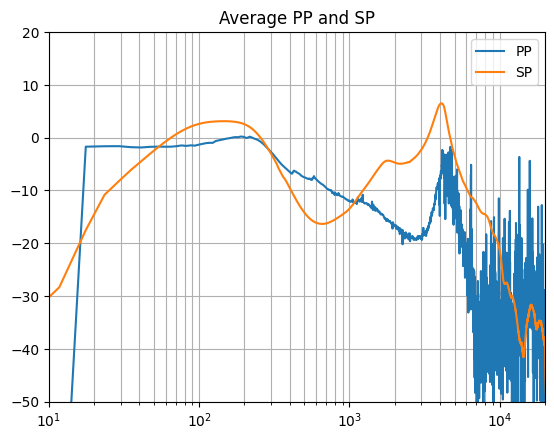

In [9]:
w, h_pp = scipy.signal.freqz(PP, 1, worN=16384, fs=fs)
w, h_sp = scipy.signal.freqz(SP, 1, worN=16384, fs=fs)

plt.semilogx(w, 20 * np.log10(np.abs(h_pp)), label="PP");
plt.semilogx(w, 20 * np.log10(np.abs(h_sp)), label="SP");

plt.grid(which="both");
plt.xlim(10, 20000);
plt.ylim(-50, 20);
plt.legend();
plt.title("Average PP and SP");

In [10]:
seed = 42

np.random.seed(seed)

In [11]:
from anc.configs import config_v0 as cfg

n_fft = cfg.n_fft
log = cfg.log
weighting = cfg.weighting

# Feedback controller design

In [12]:
problem = ProblemFeedback(fs, n_fft=n_fft, logspace=log)
problem.init(SP, weighting)


n_sections = 6

ftypes = ["ls", "hs", "pk", "pk", "pk", "pk"]
assert len(ftypes) == n_sections

parametrization = ParametrizationEQ(n_sections, ftypes, fs)
# parametrization = ParametrizationGeneral(n_sections, fs)

problem.set_parametrization(parametrization)

problem.add_constraints(cfg)

bounds = parametrization.bounds()
problem.add_bounds(bounds)

constraints = parametrization.constraints()
assert constraints is None or len(constraints) == 0

In [13]:
weights = {
    "circle": 0.0001,
    "parabola": 0.001,
    "lowfreq": 0.0001,
    "highfreq": 0.001,
}

problem_unc = problem.to_unconstrained(weights)

In [14]:
from optim.solver.heuristic import SolverMetaHeuristic

In [15]:
epoch = 200
pop_size = 500

solver = SolverMetaHeuristic(problem_unc)
solver.prepare("gwo", epoch, pop_size)
sol = solver.solve(seed=seed)

In [16]:
sos = parametrization.decode(sol)

freq, FB = problem.sosfreqz(sos)

save_sos("results/fb.csv", sos)

In [17]:
loss = problem.objective(sos)
print("Loss:", loss)

print("Constraints:")        
problem.violation(sos)

Loss: 0.66082915321246
Constraints:
[OK]:	-0.3063494394229851 	< 0 (circle)
[OK]:	-0.1669729290778602 	< 0 (parabola)
[OK]:	-0.10160337064651687 	< 0 (lowfreq)
[OK]:	-2.100812816608952 	< 0 (highfreq)


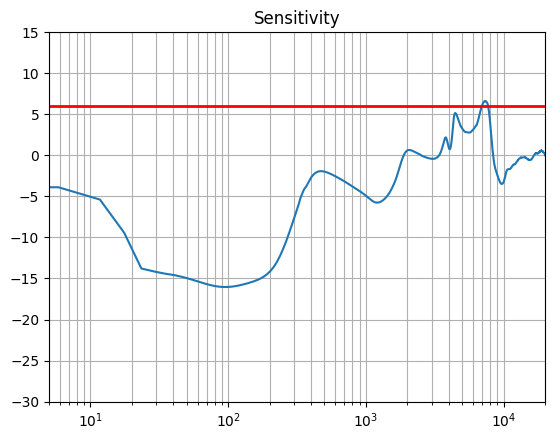

In [18]:
w, h_fb = scipy.signal.sosfreqz(sos, worN=16384, fs=fs)
w, h_sp = scipy.signal.freqz(SP, 1, worN=16384, fs=fs)
S_fb = 1 / (1 + h_fb * h_sp)

# w = np.linspace(0, fs//2, len(S_fb))
plt.semilogx(w, 20 * np.log10(np.abs(S_fb)));

x_min, x_max = 5, 20000
y_min, y_max = -30, 15

plt.plot([x_min, x_max], [cfg.gain_max, cfg.gain_max], "r", linewidth=2)

plt.grid(which="both");
plt.xlim(x_min, x_max);
plt.ylim(y_min, y_max);

plt.title("Sensitivity");

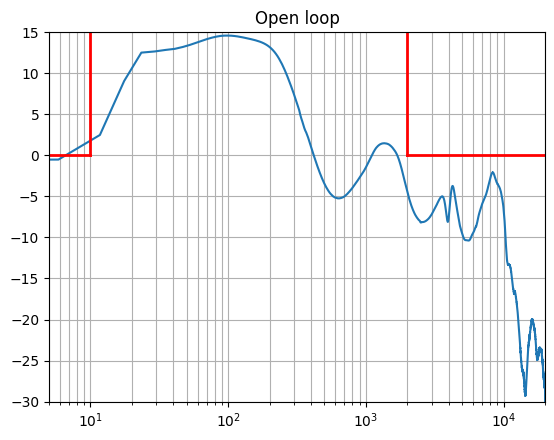

In [19]:
H = h_fb * h_sp

plt.semilogx(w, 20 * np.log10(np.abs(H)));

x_min, x_max = 5, 20000
y_min, y_max = -30, 15

plt.plot([cfg.freq_low, cfg.freq_low], [cfg.gain_open_max, y_max], "r", linewidth=2)   
plt.plot([0, cfg.freq_low], [cfg.gain_open_max, cfg.gain_open_max], "r", linewidth=2)

plt.plot([cfg.freq_high, cfg.freq_high], [cfg.gain_open_max, y_max], "r", linewidth=2)
plt.plot([cfg.freq_high, x_max], [cfg.gain_open_max, cfg.gain_open_max], "r", linewidth=2)

plt.grid(which="both");
plt.xlim(x_min, x_max);
plt.ylim(y_min, y_max);

plt.title("Open loop");

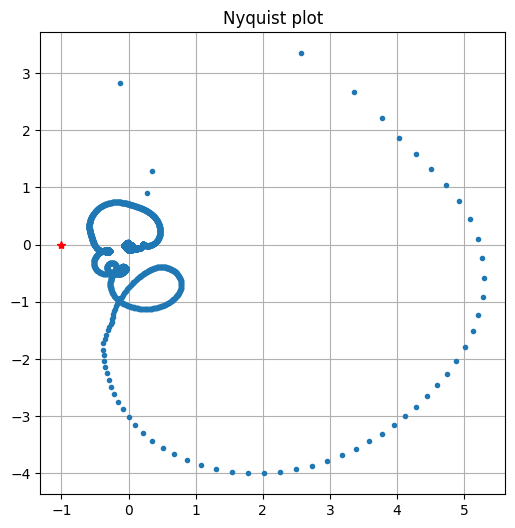

In [20]:
plt.figure(figsize=(6, 6));

plt.plot(H.real, H.imag, ".");

plt.plot(-1, 0, "r*");

# plt.xlim(-5, 5);
# plt.ylim(-5, 5);
plt.grid(which="both");
plt.title("Nyquist plot");

### Fine-tuning using gradient-based solver

In [21]:
from optim.solver.gradient import SolverGradient

In [22]:
x_init = sol

print(x_init)

[ 1.71466394e+03  6.64143478e+03  3.95125385e+03  2.35331763e+00
  3.86905427e+00  1.00000000e+00  1.42404499e+00  2.35068534e+00
  8.19136824e+00  1.00813401e-01  1.13604352e-01  1.00000000e-01
  1.00000000e+01  1.00000000e+01 -8.45473972e+00  1.00000000e+01
  1.00000000e+01  9.00422474e+00]


In [23]:
# for f in problem.get_constraints().values():
#     print(f(x_init))

slack_l, slack_u = problem.bounds.residual(x_init)
np.all(np.r_[slack_l, slack_u] > 0)

False

In [24]:
solver = SolverGradient(problem)
solver.prepare(maxiter=100)
# sol = solver.solve(x_init)

In [25]:
# sol

# Feedforward controller design

In [26]:
# Feedforward
problem_ff = ProblemFeedforward(fs, n_fft=n_fft, logspace=log)

# problem_ff.init(PP, SP, FB=None, weighting=weighting) # w/o  FB
problem_ff.init(PP, SP, FB, weighting=weighting) # w/ FB

problem_ff = problem_ff.to_unconstrained({})

In [27]:
ftypes = ["ls", "hs", "pk", "pk", "pk", "pk"]
n_sections = len(ftypes)
parametrization = ParametrizationEQ(n_sections, ftypes, fs)

problem_ff.set_parametrization(parametrization)

bounds = parametrization.bounds()

from optim.utils import unpack_bounds
problem_ff.add_bounds(bounds)

constraints = parametrization.constraints()
assert constraints is None or len(constraints) == 0

In [28]:
epoch = 100
pop_size = 500

solver_ff = SolverMetaHeuristic(problem_ff)
solver_ff.prepare("gwo", epoch, pop_size)
sol_ff = solver_ff.solve(seed=seed)

In [29]:
sos_ff = parametrization.decode(sol_ff)

save_sos("results/ff.csv", sos_ff)

In [30]:
# w, h_pp = scipy.signal.freqz(PP, 1, worN=4096, fs=fs)
# w, h_sp = scipy.signal.freqz(SP, 1, worN=4096, fs=fs)
# w, h_ff = scipy.signal.sosfreqz(sos, worN=4096, fs=fs)

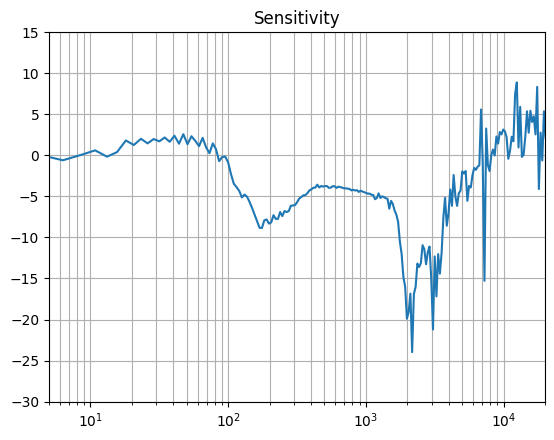

In [31]:
w0, S_ff = problem_ff.sensitivity(sos_ff)
plt.semilogx(w0, 20 * np.log10(np.abs(S_ff)));

# plt.semilogx(w, 20 * np.log10(np.abs((h_pp - h_ff * h_sp) / h_pp)));
# plt.semilogx(w, 20 * np.log10(np.abs(- h_pp / h_sp)));
# plt.semilogx(w, 20 * np.log10(np.abs(h_ff)));

plt.grid(which="both");
plt.xlim(5, 20000);
plt.ylim(-30, 15);

plt.title("Sensitivity");